In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns
import statistics

## EDA

In [2]:
n = 1000000 #number of records in file
s = 1000000 #desired sample size
filename = "tick.csv"
skip = sorted(random.sample(range(n),n-s))
df = pd.read_csv(filename, skiprows=skip, header=0)

/Users/angellei/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dates = df['3']
counts = dates.value_counts().reset_index()
counts['year'] = counts['index'].apply(lambda x: x[-4:])
data = counts.sort_values(by=['year', 'index'])
data = data.rename(index=str, columns={"index": "Date",'07/01/2016': "Count"}).drop(['year'], axis=1).reset_index(drop=True)

In [4]:
data['dayofweek'] = data['Date'].apply(lambda x: pd.Timestamp(x).dayofweek)
data['quarter'] = data['Date'].apply(lambda x: pd.Timestamp(x).quarter)
data['year'] = data['Date'].apply(lambda x: pd.Timestamp(x).year)
data['month'] = data['Date'].apply(lambda x: pd.Timestamp(x).month)

In [5]:
quarters = pd.get_dummies(data.quarter).rename({1:'Q1',2:'Q2',3:'Q3',4:'Q4'}, axis=1)
dayofweek = pd.get_dummies(data.dayofweek).rename({0:'Mon',1:'Tues',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}, axis=1)
merged = pd.merge(data, quarters, left_index=True, right_index=True)
merged = pd.merge(merged, dayofweek, left_index=True, right_index=True).drop(['Date','dayofweek','quarter','month'], axis=1)

<Figure size 7200x7200 with 0 Axes>

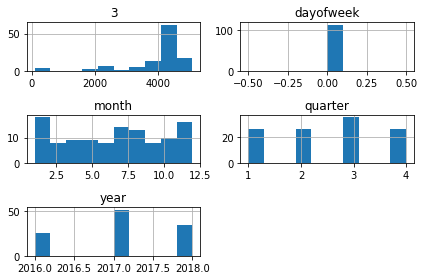

In [6]:
#Graph for all the features

plt.figure(figsize = [100,100])
data[data['dayofweek'] == 0].hist(bins=10)
plt.tight_layout()

In [7]:
merged = merged.drop(['Q1', 'Q2', 'Q3','Q4', 'Tues', 'Wed', 'Thur','Fri', 'Sat','Sun','year'], axis=1)

In [15]:
merged = merged.rename(index=str, columns={"3": "Count"})

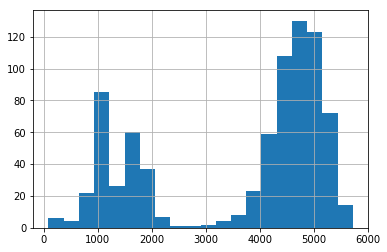

In [16]:
merged['Count'].hist(bins=20)

In [20]:
merged.iloc[276:].head()
merged = merged.iloc[276:].reset_index()

### Separate into Train and Test Dataset

In [21]:
subset = merged
train = subset[:411]
test = subset[411:]
X_train, Y_train = train[train.columns.difference(['Count'])], train.Count
X_test, Y_test = test[test.columns.difference(['Count'])], test.Count

## Linear Regression Model

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lm = LinearRegression()

In [24]:
model = lm.fit(X_train, Y_train)
train_predictions = lm.predict(X_test)

In [25]:
#Get coefficient of the features

print(lm.coef_)

[3.8880103e+02 1.6253857e-01]


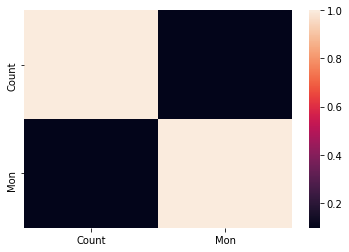

In [26]:
#Heatmap of features

corr= merged.corr()
sns.heatmap(corr)

In [27]:
x_test = X_test.index
y_test = Y_test

In [28]:
x_train = X_train.index
y_train = Y_train

In [30]:
#Additional information shown: slope, intercept, r-value, p-value, standard deviation, r-squared of the prediction line

slope, intercept, r_value, p_value, std_err = stats.linregress(x_train,y_train)
print("slope: %f" %slope) 
print("intercept: %f" %intercept)
print("r-value: %f" % r_value)
print("p-value: %f" %p_value) #is the probability of finding the observed, or more extreme, 
                #results when the null hypothesis (H0) of a study question is true. lower the better
print("std_err: %f" % std_err)
print("r-squared: %f" % r_value**2) #r2 value for the model

slope: 0.154609
intercept: 3679.964590
r-value: 0.011218
p-value: 0.820625
std_err: 0.681436
r-squared: 0.000126


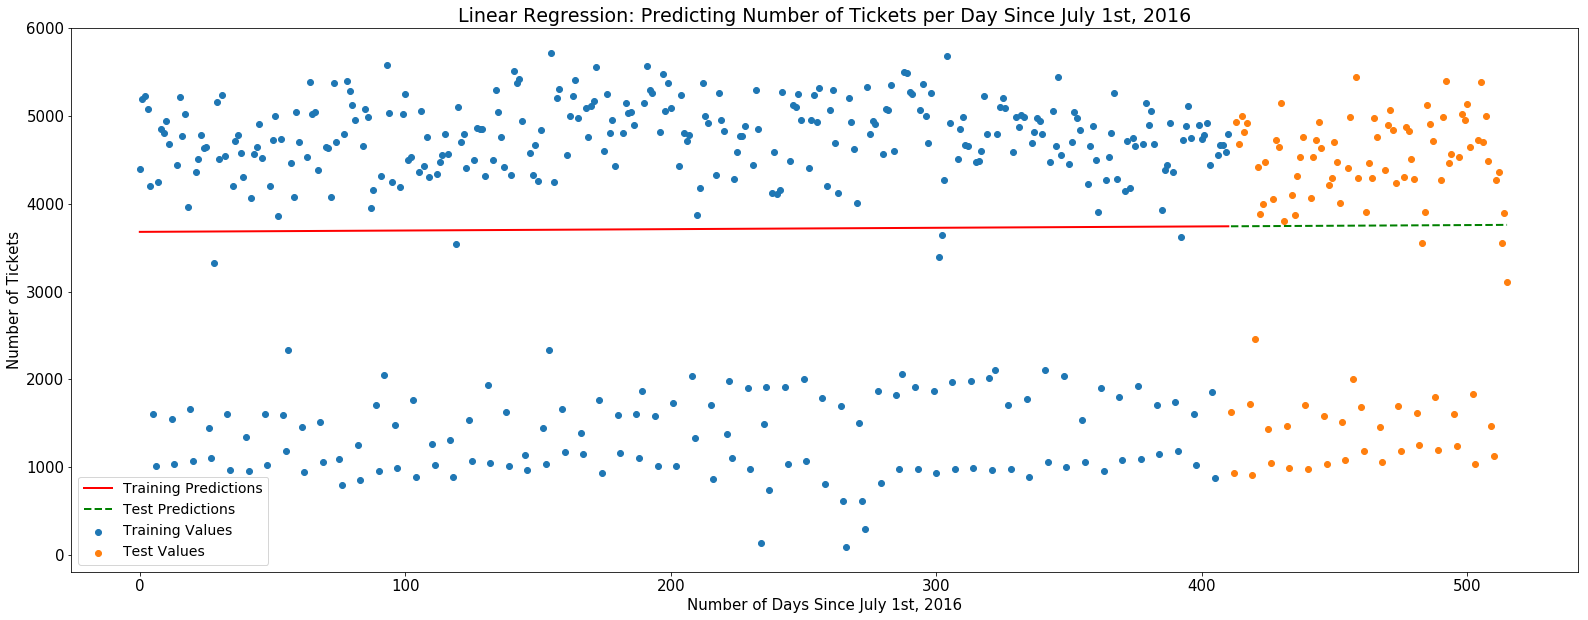

In [31]:
mn_train=min(x_train)
mx_train=max(x_train)
x1=np.linspace(mn_train,mx_train,500)

mn_train2=min(x_test)
mx_train2=max(x_test)
x2=np.linspace(mn_train2,mx_train2,500)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_train,y_train)
y1=slope*x1+intercept
y2=slope*x2+intercept

plt.figure(figsize=(27,10))
plt.scatter(x_train, y_train, label="Training Values")
plt.scatter(x_test, y_test, label="Test Values")
plt.plot(x1,y1,"r-", label="Training Predictions", linewidth=2)
plt.plot(x2,y2, "g--", label="Test Predictions", linewidth=2)
plt.legend(loc="best", fontsize=14)
plt.title('Linear Regression: Predicting Number of Tickets per Day Since July 1st, 2016', fontsize=19)
plt.xlabel('Number of Days Since July 1st, 2016', fontsize=15)
plt.ylabel('Number of Tickets', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Cross_val_score

In [622]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score

lin_score = cross_val_score(lm, x_train.values.reshape(-1,1), y_train, scoring='r2', cv=5)
lin_score.mean()

-0.0022393316747745472

### Benchmark/Baseline RMSE

In [32]:
zeros = np.zeros(105)
means = y_test.mean()
zero = zeros.fill(means)

In [33]:
#RMSE for baseline/benchmark

mse_baseline = np.sqrt(mean_squared_error(y_test, zeros))
mse_baseline

1503.47385752866

In [34]:
#y_test's standard deviation

y_test.std()

1510.6848046898729

### My model RMSE

In [37]:
#RMSE for my model
#to calculate mean square error = (y^hat - y)^2
#my y^ is just the y=mx+b predictions

mse = np.sqrt(mean_squared_error(y_test, train_predictions))
mse

1498.2256833532308

### Consider to split the graph into two to see if the result(RMSE lower) is better based on my observation on the graph there are two separate distributions

## Upper Distribution graph

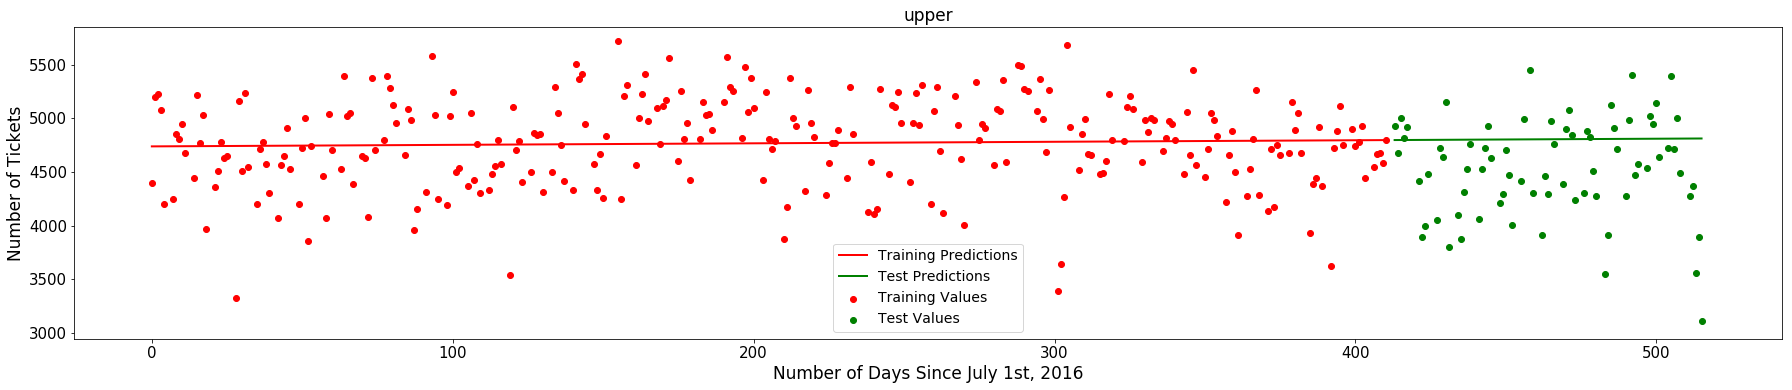

In [43]:
###upper train and test
Y_train_upper = [i for i in y_train.values if i >= 3000]
X_train_upper = [i for i in x_train if y_train[i] in Y_train_upper]
Y_test_upper = [i for i in y_test.values if i >= 3000]
X_test_upper = [i for i in x_test if y_test[i] in Y_test_upper]

# upper1 = Y_train_upper + Y_test_upper
# upper2 = X_train_upper + X_test_upper

##upper slope
mn_train=min(X_train_upper)
mx_train=max(X_train_upper)
x1_upper=np.linspace(mn_train,mx_train,500)

mn_train2=min(X_test_upper)
mx_train2=max(X_test_upper)
x2_upper=np.linspace(mn_train2,mx_train2,500)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train_upper,Y_train_upper)
y1_upper=slope*x1_upper+intercept
y2_upper=slope*x2_upper+intercept


##upper graph 
plt.figure(figsize=(25,10))
plt.subplot(211)
plt.scatter(X_train_upper, Y_train_upper, color="r", label="Training Values")
plt.scatter(X_test_upper, Y_test_upper, color="g", label="Test Values")
plt.plot(x1_upper,y1_upper, color="r", label="Training Predictions", linewidth=2)
plt.plot(x2_upper,y2_upper, color="g", label="Test Predictions", linewidth=2)
# #plt.scatter(test_upper, train_upper, label="Training Values")
plt.title('upper', fontsize=17)
plt.xlabel('Number of Days Since July 1st, 2016', fontsize=17)
plt.ylabel('Number of Tickets', fontsize=17)
plt.legend(loc="best", fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [44]:
#RMSE for baseline/benchmark

zeros = np.zeros(73)
means = sum(Y_test_upper) / len(Y_test_upper)
zero = zeros.fill(means)
mse_baseline = np.sqrt(mean_squared_error(Y_test_upper, zeros))
mse_baseline

455.31181589145416

In [45]:
statistics.stdev(Y_test_upper)

458.46264842405645

In [47]:
y2_upper = y2_upper[427:]
#y1_upper = y1_upper[427:]

In [48]:
#RMSE for my model
mse = np.sqrt(mean_squared_error(Y_test_upper, y2_upper))
mse

531.6334523960214

## Lower Distribution graph

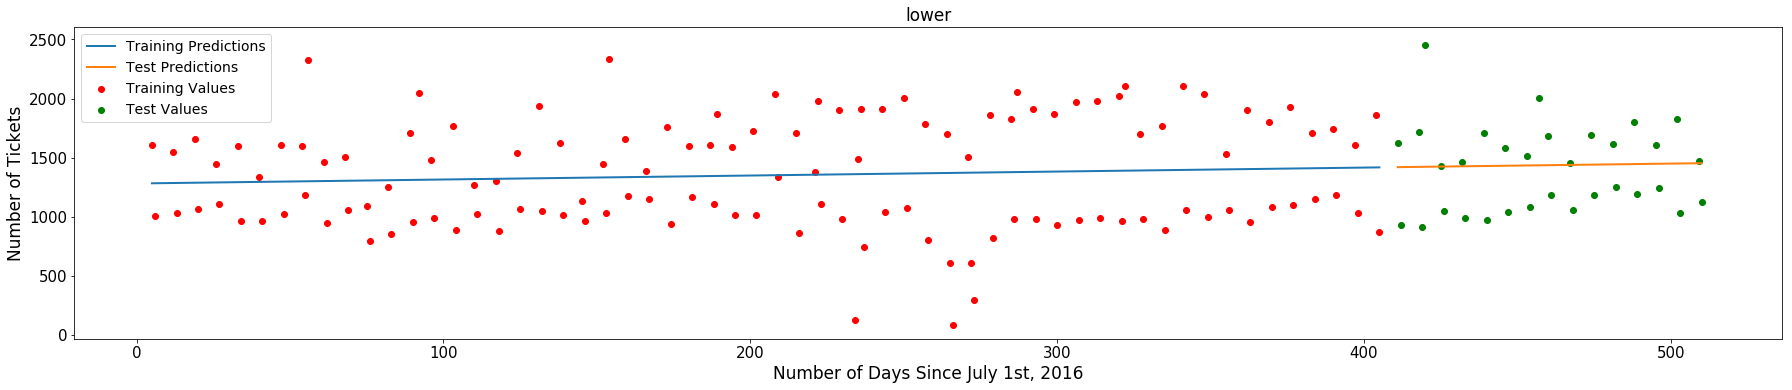

In [49]:
###lower train and test
Y_train_lower = [i for i in y_train.values if i < 3000]
X_train_lower = [i for i in x_train if y_train[i] in Y_train_lower]
Y_test_lower = [i for i in y_test.values if i < 3000]
X_test_lower = [i for i in x_test if y_test[i] in Y_test_lower]

# lower1 = Y_train_lower + Y_test_lower
# lower2 = X_train_lower + X_test_lower

##lower slope
mn_train=min(X_train_lower)
mx_train=max(X_train_lower)
x1_lower=np.linspace(mn_train,mx_train,500)

mn_train2=min(X_test_lower)
mx_train2=max(X_test_lower)
x2_lower=np.linspace(mn_train2,mx_train2,500)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train_lower,Y_train_lower)
y1_lower=slope*x1_lower+intercept
y2_lower=slope*x2_lower+intercept


##lower graph
plt.figure(figsize=(25,10))
plt.subplot(212)
plt.scatter(X_train_lower, Y_train_lower, color="r", label="Training Values")
plt.scatter(X_test_lower, Y_test_lower, color="g", label="Test Values")
plt.plot(x1_lower,y1_lower, label="Training Predictions", linewidth=2)
plt.plot(x2_lower,y2_lower, label="Test Predictions", linewidth=2)
# #plt.scatter(test_lower, train_lower)
plt.title('lower', fontsize=17)
plt.xlabel('Number of Days Since July 1st, 2016', fontsize=17)
plt.ylabel('Number of Tickets', fontsize=17)
plt.legend(loc="best", fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [53]:
#RMSE for baseline/benchmark
zeros = np.zeros(32)
means = sum(Y_test_lower) / len(Y_test_lower)
zero = zeros.fill(means)
mse_baseline = np.sqrt(mean_squared_error(Y_test_lower, zeros))
mse_baseline

355.7922278170224

In [54]:
statistics.stdev(Y_test_lower)

361.48443949912973

In [59]:
y2_lower = y2_lower[468:]

In [60]:
#RMSE for my model
mse_lower = np.sqrt(mean_squared_error(Y_test_lower, y2_lower))
mse_lower

359.0935833484283

## Using sin function and linear regression to predict

In [33]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt) #features len=50
    yy = numpy.array(yy) #target
    #Discrete Fourier Transform(dft)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))# assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy)) #fft function
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  
        return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [34]:
fit_sin(x_train,y_train)

{'amp': 1916.6462260870744,
 'omega': 0.8973992627026212,
 'phase': -2.962545382680444,
 'offset': 3685.47630230975,
 'freq': 0.1428255285861445,
 'period': 7.001549442170312,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 5293.821657533994,
 'rawres': (array([2.35655089e+03, 8.90117919e-01, 0.00000000e+00, 3.69154722e+03]),
  array([ 1.91664623e+03,  8.97399263e-01, -2.96254538e+00,  3.68547630e+03]),
  array([[ 5.29382166e+03, -6.70488916e-05,  2.63131235e-02,
          -1.67067304e+01],
         [-6.70488916e-05,  1.32992089e-07, -6.05127207e-05,
          -3.82961337e-05],
         [ 2.63131235e-02, -6.05127207e-05,  2.89726124e-02,
           2.78019290e-03],
         [-1.67067304e+01, -3.82961337e-05,  2.78019290e-03,
           2.64482266e+03]]))}

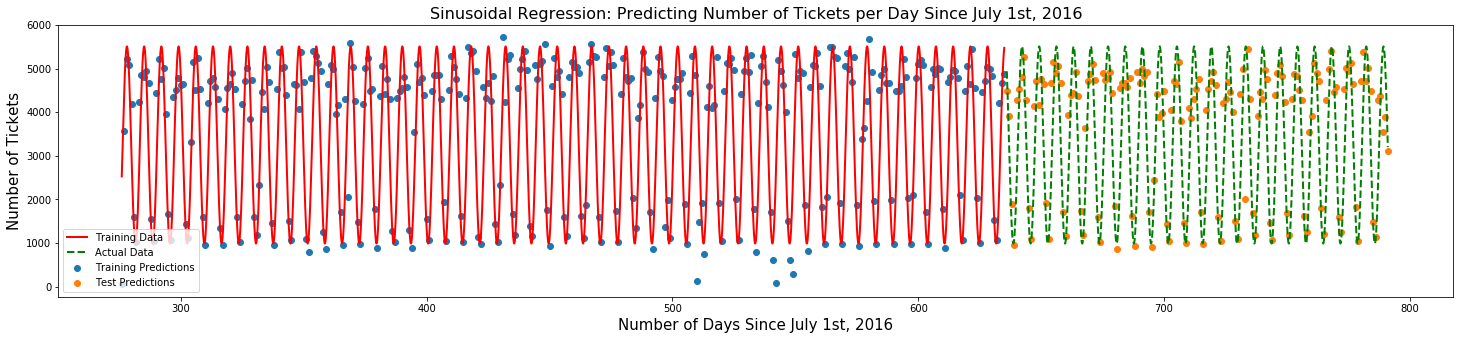

In [35]:
N, amp, omega, phase, offset, noise = 500, 1., 2., .5, 4., 3
#N, amp, omega, phase, offset, noise = 50, 1., .4, .5, 4., .2
#N, amp, omega, phase, offset, noise = 200, 1., 20, .5, 4., 1
tt = numpy.linspace(min(x_train), max(x_train), N)
tt2 = numpy.linspace(min(x_train), max(x_train), 10*N)
tt3 = numpy.linspace(min(x_test), max(x_test), 10*N)
yy = amp*numpy.sin(omega*tt + phase) + offset
yynoise = yy + noise*(numpy.random.random(len(tt))-0.5)

res = fit_sin(x_train, y_train)
# print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

plt.figure(figsize=(25,5))
plt.scatter(x_train, y_train, label="Training Values")
plt.plot(tt2, 1.18*res["fitfunc"](tt2)-1100, "r-", label="Training Predictions", linewidth=2)
plt.scatter(x_test, y_test, label="Test Values")
plt.plot(tt3, 1.18*res["fitfunc"](tt3)-1100, "g--", label="Test Predictions", linewidth=2)
plt.legend(loc="best")   
plt.title('Sinusoidal Regression: Predicting Number of Tickets per Day Since July 1st, 2016', fontsize=16)
plt.xlabel('Number of Days Since July 1st, 2016', fontsize=15)
plt.ylabel('Number of Tickets', fontsize=15)
plt.legend(['Training Data','Actual Data','Training Predictions', 'Test Predictions'])
plt.show()